# Частотный анализ на базе TF-IDF

- TF (term frequency) - отвечает за частоту встречаемости слова в текущем сообщении
- IDF (inverse document frequency) - отвечает за "редкость" слова, насколько слово редко встречается в других сообщениях

Перед запуском ноутбука запустите **MLflow Server** в консоли:

`mlflow server --host 127.0.0.1 --port 8080`

In [12]:
# Путь до корневой папки проекта _относительно папки запуска этого скрипта_
import os

ABSOLUTE_PATH = os.path.abspath("../../")

In [13]:
# Параметры для данного ноутбука (не нужны в общем конфиге)
TASK_NAME       = "TF/IDF Embeddings"
EXPERIMENT_NAME = "Embedding_50K_v2"
RUN_NAME        = "tfidf_embeddings"    # Часть пути, без пробелов и спецсимволов!

Загружаем параметры из файла конфигурации

In [14]:
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf

GlobalHydra.instance().clear()

# Hydra context initialization
initialize(version_base=None, config_path=".", job_name=TASK_NAME)
cfg = compose(config_name="config")

# print(OmegaConf.to_yaml(cfg))

Загружаем датасет

In [15]:
import os
import polars as pl

data = pl.read_csv(
    os.path.join(ABSOLUTE_PATH, cfg.paths.data, cfg.files.train_data),
    has_header=False,
    new_columns=["Polarity", "Title", "Review"],
    n_rows=cfg.params.nrows,
)

pl.Config.set_fmt_str_lengths(100)
data.head(3)

shape: (3, 3)
┌──────────┬───────────────────────────────────────┬───────────────────────────────────────────────┐
│ Polarity ┆ Title                                 ┆ Review                                        │
│ ---      ┆ ---                                   ┆ ---                                           │
│ i64      ┆ str                                   ┆ str                                           │
╞══════════╪═══════════════════════════════════════╪═══════════════════════════════════════════════╡
│ 2        ┆ Stuning even for the non-gamer        ┆ This sound track was beautiful! It paints the │
│          ┆                                       ┆ senery in your mind so well I would recomend  │
│          ┆                                       ┆ it even t…                                    │
│ 2        ┆ The best soundtrack ever to anything. ┆ I'm reading a lot of reviews saying that this │
│          ┆                                       ┆ is the best 'game soundtrack' and I figured   │
│          ┆                                       ┆ that I'd w…                                   │
│ 2        ┆ Amazing!                              ┆ This soundtrack is my favorite music of all   │
│          ┆                                       ┆ time, hands down. The intense sadness of      │
│          ┆                                       ┆ "Prisoners of F…                              │
└──────────┴───────────────────────────────────────┴───────────────────────────────────────────────┘

In [16]:
data = data.select('Polarity', 'Review').with_columns(
    pl.col("Polarity").map_elements(
        lambda polarity: "Negative" if polarity == 1 else "Positive"
    )
)

/tmp/ipykernel_1651/553745447.py:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  data = data.select('Polarity', 'Review').with_columns(


Проверяем, что датасет сбалансирован по отзывам

In [17]:
data['Polarity'].value_counts()

shape: (2, 2)
┌──────────┬───────┐
│ Polarity ┆ count │
│ ---      ┆ ---   │
│ str      ┆ u32   │
╞══════════╪═══════╡
│ Positive ┆ 25506 │
│ Negative ┆ 24494 │
└──────────┴───────┘

Предобработка текста и лемматизатор

*ВАЖНО: не использовать этот лемматизатор для русского языка, т.к. уничтожит падежи!*

In [18]:
from nltk.corpus import stopwords
import nltk
import re

nltk.download('wordnet')
nltk.download("stopwords")

# Предварительная компиляция шаблонов регулярок - ускорение в ≈60 раз
stop_words = set(stopwords.words("english"))
url_pattern = re.compile(r"https?://\S+|www\.\S+|\[.*?\]|[^a-zA-Z\s]+|\w*\d\w*")
spec_chars_pattern = re.compile("[0-9_-]+")
non_alpha_pattern = re.compile("[^a-zA-Z]+")


def preprocessing(input_text: str) -> str:
    text = input_text.lower()                   # приведение к нижнему регистру
    text = url_pattern.sub("", text)            # убираем ссылки
    text = spec_chars_pattern.sub(" ", text)    # убираем спец символы
    text = non_alpha_pattern.sub(" ", text)     # оставляем только буквы

    text = " ".join([word for word in text.split() if word not in stop_words])
    return text.strip()


data = data.with_columns(
    pl.col('Review').map_elements(preprocessing).str.split(' ').alias('corpus')
)

data.head(3)

[nltk_data] Downloading package wordnet to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


shape: (3, 3)
┌──────────┬───────────────────────────────────────────────┬───────────────────────────────────────┐
│ Polarity ┆ Review                                        ┆ corpus                                │
│ ---      ┆ ---                                           ┆ ---                                   │
│ str      ┆ str                                           ┆ list[str]                             │
╞══════════╪═══════════════════════════════════════════════╪═══════════════════════════════════════╡
│ Positive ┆ This sound track was beautiful! It paints the ┆ ["sound", "track", … "listen"]        │
│          ┆ senery in your mind so well I would recomend  ┆                                       │
│          ┆ it even t…                                    ┆                                       │
│ Positive ┆ I'm reading a lot of reviews saying that this ┆ ["im", "reading", … "penny"]          │
│          ┆ is the best 'game soundtrack' and I figured   ┆                                       │
│          ┆ that I'd w…                                   ┆                                       │
│ Positive ┆ This soundtrack is my favorite music of all   ┆ ["soundtrack", "favorite", … "stars"] │
│          ┆ time, hands down. The intense sadness of      ┆                                       │
│          ┆ "Prisoners of F…                              ┆                                       │
└──────────┴───────────────────────────────────────────────┴───────────────────────────────────────┘

In [19]:
from nltk.stem import WordNetLemmatizer

def lemmatize(input_frame: pl.DataFrame) -> pl.DataFrame:
    lemmatizer = WordNetLemmatizer()

    return input_frame.with_columns(
        pl.col("corpus").map_elements(
            lambda input_list: [lemmatizer.lemmatize(token) for token in input_list]
        )
    )
    
processed_data = lemmatize(data)
processed_data.head(3)

/tmp/ipykernel_1651/2055772167.py:6: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  return input_frame.with_columns(


shape: (3, 3)
┌──────────┬────────────────────────────────────────────────┬──────────────────────────────────────┐
│ Polarity ┆ Review                                         ┆ corpus                               │
│ ---      ┆ ---                                            ┆ ---                                  │
│ str      ┆ str                                            ┆ list[str]                            │
╞══════════╪════════════════════════════════════════════════╪══════════════════════════════════════╡
│ Positive ┆ This sound track was beautiful! It paints the  ┆ ["sound", "track", … "listen"]       │
│          ┆ senery in your mind so well I would recomend   ┆                                      │
│          ┆ it even t…                                     ┆                                      │
│ Positive ┆ I'm reading a lot of reviews saying that this  ┆ ["im", "reading", … "penny"]         │
│          ┆ is the best 'game soundtrack' and I figured    ┆                                      │
│          ┆ that I'd w…                                    ┆                                      │
│ Positive ┆ This soundtrack is my favorite music of all    ┆ ["soundtrack", "favorite", … "star"] │
│          ┆ time, hands down. The intense sadness of       ┆                                      │
│          ┆ "Prisoners of F…                               ┆                                      │
└──────────┴────────────────────────────────────────────────┴──────────────────────────────────────┘

Разбиваем на тренировочную и тестовую выборки, получаем признаки для train и test

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

vectorizer_params = {
    "max_features": cfg.params.max_features,
    "analyzer": "word"
}

tfidf_vectorizer = TfidfVectorizer(**vectorizer_params)

train, test = train_test_split(
    processed_data,
    test_size=cfg.params.test_size,
    shuffle=cfg.params.shuffle,
    random_state=cfg.params.random_state,
)

tfidf_vectorizer.fit(train["corpus"].to_pandas().astype(str))

train_features = tfidf_vectorizer.transform(train["corpus"].list.join(" ").to_numpy())
test_features = tfidf_vectorizer.transform(test["corpus"].list.join(" ").to_numpy())

Вспомогательный код для отрисовки Confusion матрицы

In [21]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.figure import Figure
from sklearn.metrics import (
    ConfusionMatrixDisplay,
)

def conf_matrix(y_true: np.ndarray, pred: np.ndarray) -> Figure:
    plt.ioff()
    fig, ax = plt.subplots(figsize=(5, 5))
    ConfusionMatrixDisplay.from_predictions(y_true, pred, ax=ax, colorbar=False)
    ax.xaxis.set_tick_params(rotation=90)
    _ = ax.set_title(f"Confusion Matrix")
    plt.tight_layout()
    return fig

Используем **MLflow** для логирования результатов обучения логистической регрессии

2024/05/19 18:22:30 INFO mlflow.tracking.fluent: Experiment with name 'Embedding_50K_v2' does not exist. Creating a new experiment.


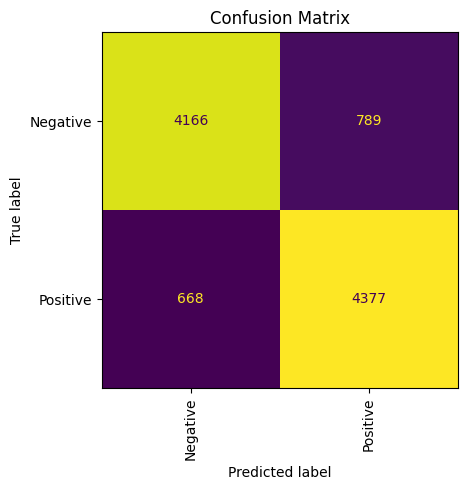

In [22]:
import mlflow
from sklearn.metrics import classification_report

# Подключение к серверу MLflow
mlflow.set_tracking_uri("http://127.0.0.1:8080")

# Зафиксируем текущее название эксперимента
mlflow.set_experiment(EXPERIMENT_NAME)


with mlflow.start_run(run_name=RUN_NAME) as run:
    model_params = {
        "random_state": cfg.params.random_state,
        "multi_class": "multinomial",
        "solver": "saga",
    }
    
    model_lr = LogisticRegression(**model_params)
    model_lr.fit(train_features, train["Polarity"])
    
    predicts = model_lr.predict(test_features)
    
    report = classification_report(test["Polarity"], predicts, output_dict=True)

    # логирование метрик из classification report
    mlflow.log_metric("accuracy", report.pop("accuracy"))
    for class_or_avg, metrics_dict in report.items():
        if class_or_avg == 'macro avg':
            break
        for metric, value in metrics_dict.items():
            mlflow.log_metric(class_or_avg + '_' + metric, value)
    
    # Логирование параметров модели
    mlflow.log_params(vectorizer_params) 
    mlflow.log_params(model_params)

    # Логирование целой модели для переиспользование
    mlflow.sklearn.log_model(
        sk_model=model_lr, 
        input_example=test_features[:10], 
        artifact_path=f"mlflow/{RUN_NAME}/model"
    )
    
     # Получение confusion matrix на два класса
    fig = conf_matrix(test["Polarity"], predicts)
    
    # Логирование фигур или целых артефактов
    mlflow.log_figure(fig, f'{RUN_NAME}_confusion_matrix.png')